In [1]:
# Import necessary libraries
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# Get a list of all CSV files in the folder
csv_files_train = glob.glob("train/*.csv")
csv_files_test = glob.glob("test/*.csv")
csv_files_closest = glob.glob("closest/*.csv")


# Initialize an empty list to hold the DataFrames
df_train_list = []
df_test_list = []
df_closest_list = []

# Loop through each CSV file and load it into a DataFrame, then append it to the list
for file in csv_files_train:
    df = pd.read_csv(file)
    df_train_list.append(df)
    
for file in csv_files_test:
    df = pd.read_csv(file)
    df_test_list.append(df)
    
for file in csv_files_closest:
    df = pd.read_csv(file)
    df_closest_list.append(df)


In [3]:
# Loop through each DataFrame in the list and drop the specified columns
for i in range(len(df_train_list)):
    df_train_list[i] = df_train_list[i].drop(['Unnamed: 0', 'name', 'address', 'city', 'state', 'categories'], axis=1)
    

for i in range(len(df_test_list)):
    df_test_list[i] = df_test_list[i].drop(['Unnamed: 0', 'name', 'address', 'city', 'state', 'categories'], axis=1)
    
# for i in range(len(df_closest_list)):
#     df_test_list[i] = df_test_list[i].drop(['Unnamed: 0', 'name', 'address', 'city', 'state', 'categories'], axis=1)

mae  0.8514862025867467  for user number  0


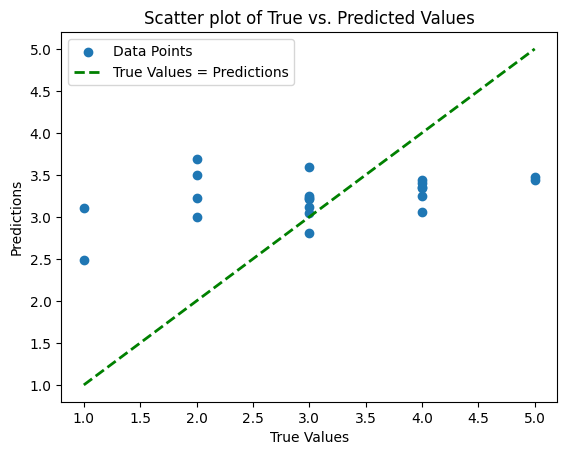

mae  0.7127217609756971  for user number  1


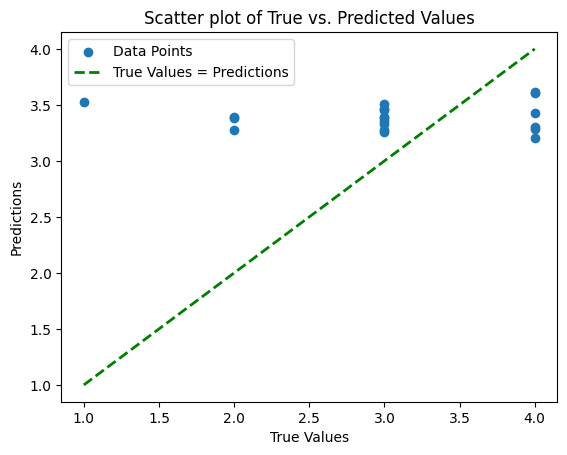

mae  0.7226673312579321  for user number  2


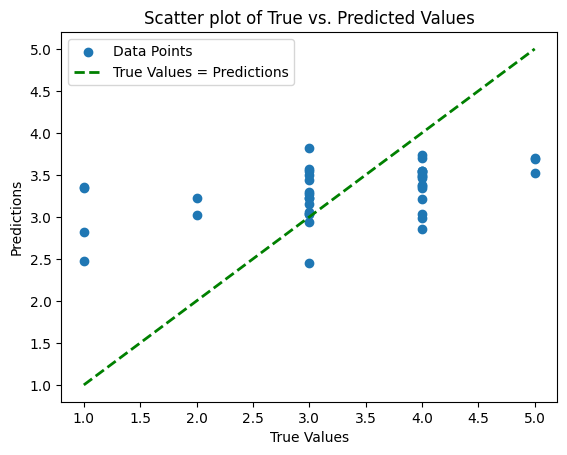

mae  0.7694808761974807  for user number  3


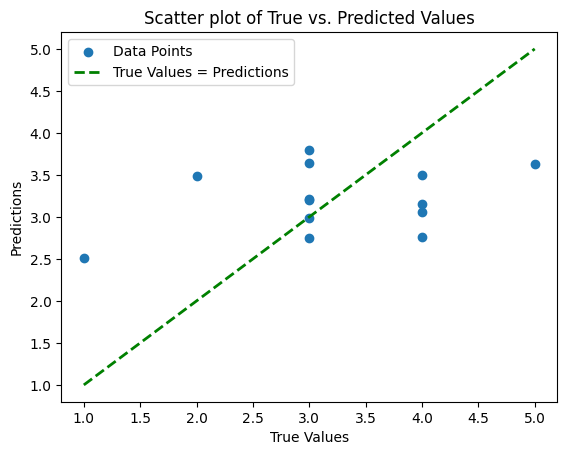

In [4]:
for i in range(len(df_train_list)):
# for i in range(1):
    # Get the first DataFrame in the list
    df_train = df_train_list[i]
    df_test = df_test_list[i]
    df_test_closest = df_closest_list[i]
    # print(df.columns)
    #print(df)
    
    # Split the data into training and testing sets
    
    # X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=50)
    X_train = df_train.iloc[:,:-1]
    X_test = df_test.iloc[:,:-1]
    y_train = df_train.iloc[:,-1]
    y_test = df_test.iloc[:,-1]
    

    
    
    #get an x features for the restaurants in the closest set
    X_test_closest = df_test_closest.iloc[:,5:]
    X_test_closest.drop(['categories'], axis=1, inplace=True)
    
    

    random_forest = RandomForestRegressor(random_state=50)
    
    num_vars = ["latitude", "longitude", "stars", "review_count"]
    
    cat_vars = ['is_American',
                'is_Dessert', 'is_Bar', 'is_Beer,Wine,Spirits', 'is_Breakfast',
                'is_Coffee & Tea', 'is_Asian', 'is_Italian',
                'is_Healthy,Specialty Food', 'is_Latin American', 'is_Mediterranean',
                'is_Western European', 'is_Slavic Food', 'is_African',
                'is_Food Markets/Shops']
    
    X_train_cat = X_train[cat_vars]
    X_train_cat = X_train_cat.reset_index(drop=True)
    X_test_cat = X_test[cat_vars]
    X_test_cat = X_test_cat.reset_index(drop=True)
    X_test_closest_cat = X_test_closest[cat_vars]
    X_test_closest_cat = X_test_closest_cat.reset_index(drop=True)
    
    # print(X_train_cat)
    
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    
    data_pipeline = ColumnTransformer([
        ('numerical', num_pipeline, num_vars)
    ])
    
    X_train_processed = data_pipeline.fit_transform(X_train)
    
    X_test_processed = data_pipeline.transform(X_test)
    
    X_test_closest_processed = data_pipeline.transform(X_test_closest)
    
    X_train_processed = pd.DataFrame(X_train_processed)
    X_train_processed = X_train_processed.reset_index(drop=True)
    X_test_processed = pd.DataFrame(X_test_processed)
    X_test_processed = X_test_processed.reset_index(drop=True)
    X_test_closest_processed = pd.DataFrame(X_test_closest_processed)
    X_test_closest_processed = X_test_closest_processed.reset_index(drop=True)
    
    
    X_train_processed_total = pd.concat([X_train_processed, X_train_cat], axis=1, ignore_index=True)
    X_test_processed_total = pd.concat([X_test_processed, X_test_cat], axis=1, ignore_index=True)
    X_test_closest_processed_total = pd.concat([X_test_closest_processed, X_test_closest_cat], axis=1, ignore_index=True)
    # print(len(X_train_processed_total))
    # print(X_train_processed_total)

    
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
        'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
        'max_features': ['sqrt', 'log2', None]
    }
    
    search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=50)
    
    search_rf.fit(X_train_processed_total, y_train)
    
    # Initialize a random forest regression model
    model = RandomForestRegressor(n_estimators=search_rf.best_params_['n_estimators'], 
                                  max_depth=search_rf.best_params_['max_depth'], 
                                  max_features=search_rf.best_params_['max_features'],
                                  random_state=50)

    
   
    # Train the model on the training data
    model.fit(X_train_processed_total, y_train)
    # Predict rating on test data
    y_pred = model.predict(X_test_processed_total)
    
    y_pred_closest = model.predict(X_test_closest_processed_total)
  
    df_closest_list[i]['Predicted_Rating'] = y_pred_closest
    
    """
    I want to make a y-closest pred and add it on a column
    to the df that contains the closest
    df_closest_list[i] 
    xclosets is df closest df.iloc[:, 6:-1]
    
    
    
    
    """
    
    

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print("mae ", mae, " for user number ", i)# )#, " mse ",mse, " rmse ", rmse, " for user number ", i)

   
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', linewidth=2)  # add the green line
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Scatter plot of True vs. Predicted Values')
    plt.legend([ 'Data Points','True Values = Predictions'])
    plt.show()


In [5]:
df_closest_list[i].columns

Index(['Unnamed: 0', 'name', 'address', 'city', 'state', 'latitude',
       'longitude', 'stars', 'review_count', 'categories', 'is_American',
       'is_Dessert', 'is_Bar', 'is_Beer,Wine,Spirits', 'is_Breakfast',
       'is_Coffee & Tea', 'is_Asian', 'is_Italian',
       'is_Healthy,Specialty Food', 'is_Latin American', 'is_Mediterranean',
       'is_Western European', 'is_Slavic Food', 'is_African',
       'is_Food Markets/Shops', 'Predicted_Rating'],
      dtype='object')

In [ ]:
# sort it by Predicted_Rating for all 4
# drop all training columns
# put each into csv

for i in range(len(df_closest_list)):
    df_closest_list[i].sort_values(by='Predicted_Rating', ascending=False, inplace=True)
    df_closest_list[i].drop(['stars', 'review_count', 'categories', 'is_American',
                             'is_Dessert', 'is_Bar', 'is_Beer,Wine,Spirits', 'is_Breakfast',
                             'is_Coffee & Tea', 'is_Asian', 'is_Italian',
                             'is_Healthy,Specialty Food', 'is_Latin American', 'is_Mediterranean',
                             'is_Western European', 'is_Slavic Food', 'is_African',
                             'is_Food Markets/Shops'], axis=1, inplace=True)


In [9]:
df_closest_list[0].to_csv('closest_ranking/JeDgLoAcyBL87FAT4xNA_ranking.csv', index=False)
df_closest_list[1].to_csv('closest_ranking/4wFZgzj4DXB3Mn7Q1WLhXg_ranking.csv', index=False)
df_closest_list[2].to_csv('closest_ranking/6Q8dQGr_DBKcmQ1aXVWvTQ_ranking.csv', index=False)
df_closest_list[3].to_csv('closest_ranking/IHNqLX2tHqGzULVYKmpQkw_ranking.csv', index=False)
